In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
# import the data using pandas
housing_df = pd.read_csv("sample_submission.csv")
# show first five rows to make sure data loads correctly
housing_df.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [5]:
# print the rows and columns of the dataset
print(housing_df.shape)
# show me what percentage of the data is missing for each column in dataset
(housing_df.isnull().sum()/housing_df.isnull().count()).sort_values(ascending=False)

(1459, 2)


Id           0.0
SalePrice    0.0
dtype: float64

In [6]:
# perform descriptive statistics
describe = housing_df["SalePrice"].describe()
# draw some conclusions
print("The price range in which 68% of the prices lie is from: ${} - ${}".format(round((describe[1]-describe[2]),2),round((describe[1]+describe[2]),2)))
describe

The price range in which 68% of the prices lie is from: $162665.62 - $195702.22


count      1459.000000
mean     179183.918243
std       16518.303051
min      135751.318893
25%      168703.011202
50%      179208.665698
75%      186789.409363
max      281643.976117
Name: SalePrice, dtype: float64

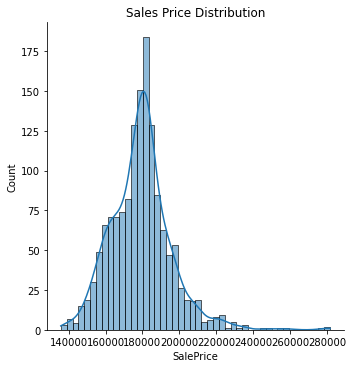

In [7]:
# show a distribution and histogram plot of the sales price using seaborn
ax = sns.displot(housing_df, x="SalePrice", kde=True)
ax.set(title="Sales Price Distribution")

In [8]:
# read in data and display
train_df = pd.read_csv("train.csv")
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [9]:
# show what % of data is missing in descending order
# since Id shows no missing data any column beneath it has all its' data
print(train_df.shape)
(train_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending=False).iloc[0:20]

(1460, 81)


PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
FireplaceQu     0.472603
LotFrontage     0.177397
GarageYrBlt     0.055479
GarageCond      0.055479
GarageType      0.055479
GarageFinish    0.055479
GarageQual      0.055479
BsmtFinType2    0.026027
BsmtExposure    0.026027
BsmtQual        0.025342
BsmtCond        0.025342
BsmtFinType1    0.025342
MasVnrArea      0.005479
MasVnrType      0.005479
Electrical      0.000685
Id              0.000000
dtype: float64

In [10]:
# obtain the column names with string data types
categorical_data = []

for i in range(len(train_df.dtypes)):
    if "64" not in str(train_df.dtypes[i]):
        categorical_data.append(train_df.columns[i])

# Reading the data description doc I see some of the numerical data represents categorical information
# This fact is accounted for here and is added to the categorical dataset
cat_data = ["MSSubClass","OverallQual","OverallCond","YearBuilt","YearRemodAdd",
           "BsmtFullBath","BsmtHalfBath","FullBath","HalfBath","BedroomAbvGr",
           "KitchenAbvGr","TotRmsAbvGrd","GarageYrBlt","MoSold","YrSold"]

categorical_data += cat_data

# perform descriptive statistics on categorical data
train_df[categorical_data].astype('category').describe().T

,count,unique,top,freq
MSZoning,1460,5,RL,1151
Street,1460,2,Pave,1454
Alley,91,2,Grvl,50
LotShape,1460,4,Reg,925
LandContour,1460,4,Lvl,1311
Utilities,1460,2,AllPub,1459
LotConfig,1460,5,Inside,1052
LandSlope,1460,3,Gtl,1382
Neighborhood,1460,25,NAmes,225
Condition1,1460,9,Norm,1260


In [11]:
# obtain the column names with numerical data types
numerical_data = []

for i in range(len(train_df.dtypes)):
    if "64" in str(train_df.dtypes[i]):
        numerical_data.append(train_df.columns[i])
        
# remove Id column as it provides no insight
numerical_data.remove("Id")

# remove the categorical data we found previously
for num_data in numerical_data:
        if num_data in categorical_data:
            numerical_data.remove(num_data)
numerical_data.remove("KitchenAbvGr")
numerical_data.remove("OverallCond")
numerical_data.remove("BsmtHalfBath")
numerical_data.remove("HalfBath")

# perform descriptive statistics on numerical data
train_df[numerical_data].describe().T

,count,mean,std,min,25%,50%,75%,max
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0
BsmtFinSF2,1460.0,46.549315,161.319273,0.0,0.00,0.0,0.00,1474.0
BsmtUnfSF,1460.0,567.240411,441.866955,0.0,223.00,477.5,808.00,2336.0
TotalBsmtSF,1460.0,1057.429452,438.705324,0.0,795.75,991.5,1298.25,6110.0
1stFlrSF,1460.0,1162.626712,386.587738,334.0,882.00,1087.0,1391.25,4692.0
2ndFlrSF,1460.0,346.992466,436.528436,0.0,0.00,0.0,728.00,2065.0


Text(0.5, 1.0, 'Distribution of Sale Price over Street Type per Zoning Classification')

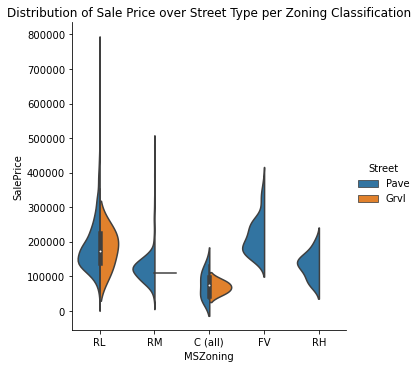

In [12]:
# As we can see there are little to no Gravel street types for Classifications RM, FV, and RH
sns.catplot(x="MSZoning", y="SalePrice", hue="Street",kind="violin",split=True, data=train_df)
plt.title("Distribution of Sale Price over Street Type per Zoning Classification")

Text(0.5, 1.0, 'Distribution of Sale Price over Alley Type per Zoning Classification')

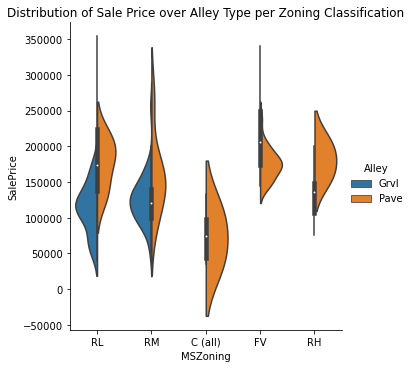

In [13]:
# Using Alley Type instead of Street Type we obtain nearly the opposite shading
# There is virtually no Gravel types for Zones C, FV, and RH
sns.catplot(x="MSZoning", y="SalePrice", hue="Alley",kind="violin",split=True, data=train_df)
plt.title("Distribution of Sale Price over Alley Type per Zoning Classification")

As we can see there is a cyclical nature to the sale of homes


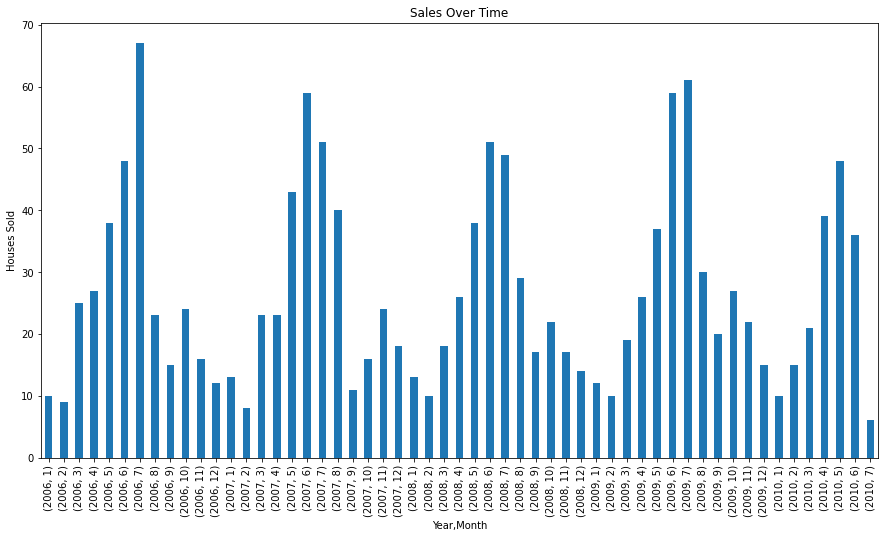

In [14]:
# group sales by year and month then count sales
date_df = train_df.groupby("YrSold")["MoSold"].value_counts()

# plot results
date_df.sort_index().plot(kind="bar",figsize=(15,8),title="Sales Over Time",
                          xlabel="Year,Month",ylabel="Houses Sold")
# draw insights
print("As we can see there is a cyclical nature to the sale of homes")

In [15]:
# group sales by Year and Month then count sales
date_sold = train_df.groupby("YrSold")["MoSold"].value_counts().unstack().fillna(0)

# convert month number to month name for readability    
import datetime
mon_name = []
for mon_num in date_sold.T.index:
    name = datetime.datetime.strptime(str(mon_num),"%m").strftime("%b")
    mon_name.append(name)

From this area graph we can see 47.3% of total sales occur between the 3 months of May, June, and July.


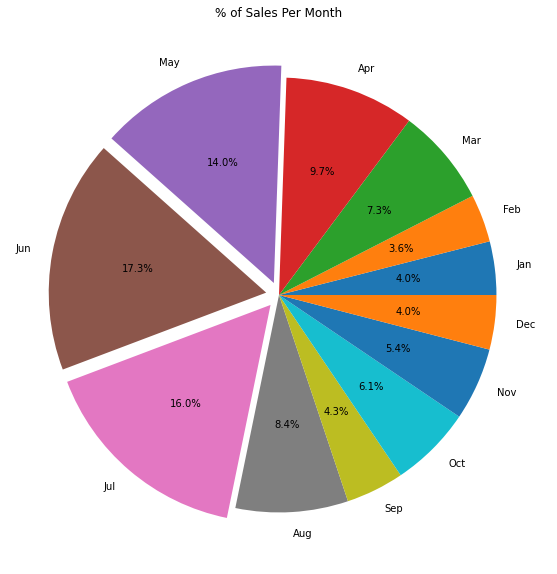

In [16]:
# sum number of houses sold in each year for each month
yoy = round(date_sold.sum())

explode = [0,0,0,0,0.06,0.06,0.06,0,0,0,0,0]
yoy.groupby(['MoSold']).sum().plot(kind='pie',figsize=(15,10),autopct='%1.1f%%',labels=mon_name,explode=explode)
plt.title("% of Sales Per Month")
plt.ylabel("")

sales_percent = 100*round((date_sold.sum().iloc[4:7].sum()/date_sold.sum().sum()),3)
print("From this area graph we can see {}% of total sales occur between the 3 months of May, June, and July.".format(sales_percent))

As we can expect, revenue is related to sales volume.


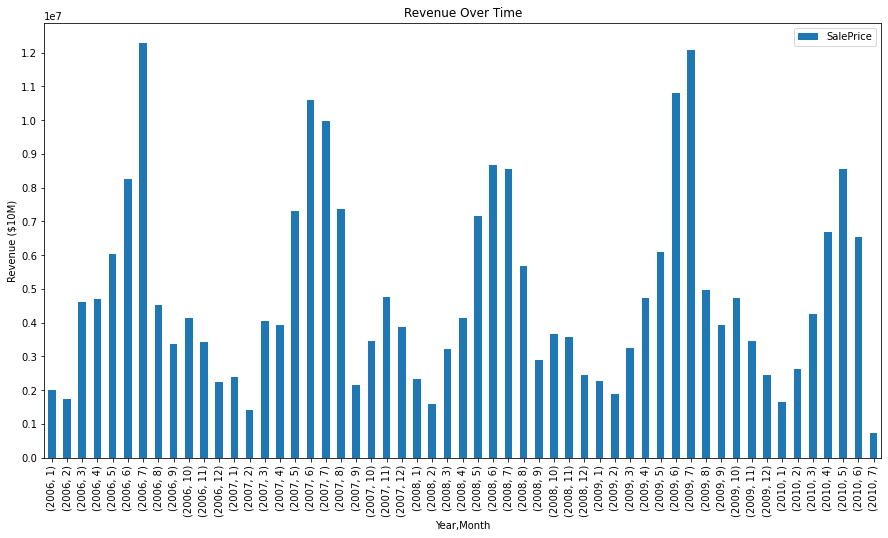

In [17]:
# create a dataframe of dates and selling prices
revenue_df = train_df[["YrSold","MoSold","SalePrice"]]
# group dates by year and month then sum over all sales revenue
revenue_groups = revenue_df.groupby(["YrSold","MoSold"]).sum()
# plot results
ax = revenue_groups.plot(
kind="bar",figsize=(15,8),title="Revenue Over Time",
xlabel="Year,Month",ylabel="Revenue ($10M)",yticks=range(0,13000000,10**6))
print("As we can expect, revenue is related to sales volume.")

As expected, we can see that 46.8% of total revenue comes from May, June, and July


Text(0, 0.5, '')

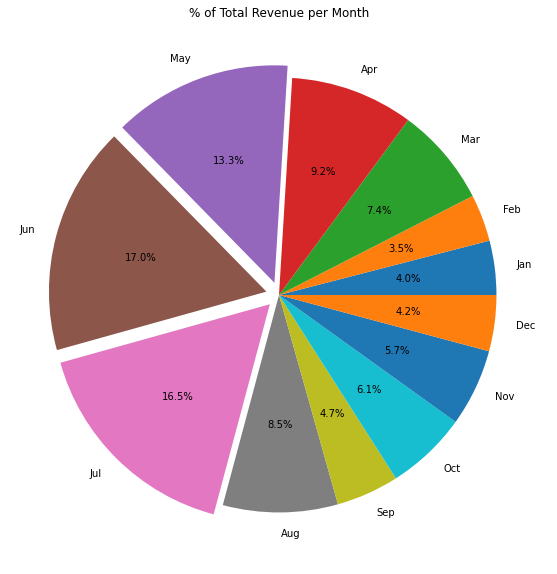

In [18]:
# sum all sales revenue for each month for all years
monthly_rev = revenue_groups[["SalePrice"]].groupby(["MoSold"]).sum()
# sales revenue as a % from May, June, July
rev_percent = 13.3+17.0+16.5
# draw insights and plot results
print("As expected, we can see that {}% of total revenue comes from May, June, and July".format(rev_percent))
monthly_rev.plot(kind='pie',figsize=(15,10),legend=False,autopct='%1.1f%%',labels=mon_name,explode=explode,subplots=True)
plt.title("% of Total Revenue per Month")
plt.ylabel("")

Perhaps counter-intuitively, while sales volume and revenue typically peak in the month of June, the average price of a home peaks in September.


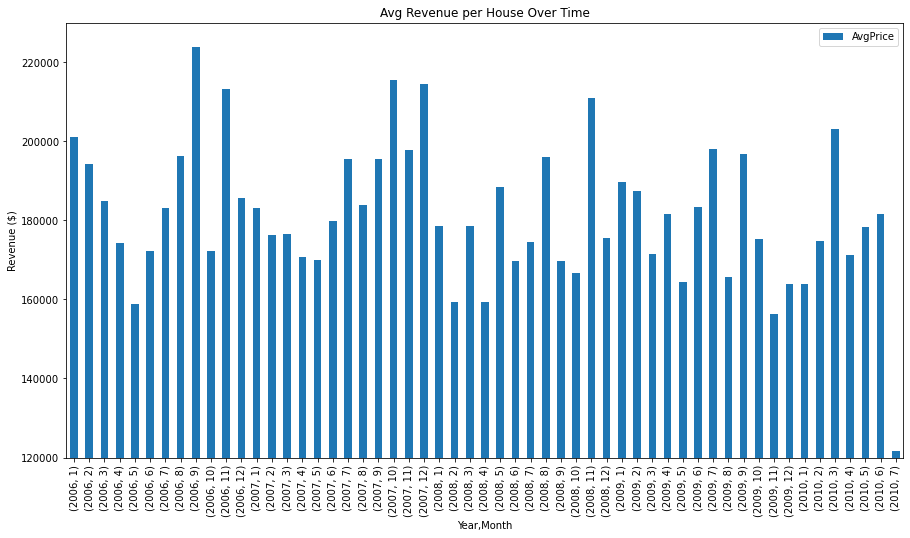

In [19]:
# get amount of houses sold per date
date_df_sort = date_df.sort_index()
# add amount of houses sold to revenue dataframe
revenue_groups["AmountSold"] = date_df_sort.values
# calculate average selling price of home per date and round to nearest cent
revenue_groups["AvgPrice"] = round((revenue_groups["SalePrice"]/revenue_groups["AmountSold"]),2)
# plot results
avgSales_df = revenue_groups[["AvgPrice"]]
ax = avgSales_df.plot(
kind="bar",figsize=(15,8),title="Avg Revenue per House Over Time",
xlabel="Year,Month",ylabel="Revenue ($)",ylim=(120000,230000))
# draw insights
print("Perhaps counter-intuitively, while sales volume and revenue typically peak in the "+
     "month of June, the average price of a home peaks in September.")

It seems there are too few houses with pools to draw any concrete conclusions, however, we may be able to say houses with larger and higher quality pools have higher retail value.


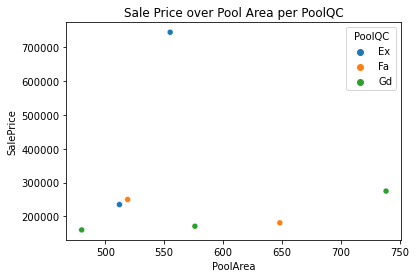

In [20]:
# How does a pool affect home price?

# create dataframe containing pool data
pool_df = train_df[["PoolQC","PoolArea","SalePrice"]].replace(np.nan,"None")
# create dataframe containing houses with pools
yes_pool = pool_df[pool_df["PoolQC"] != "None"]
# create dataframe containing houses without pools
no_pool = pool_df[train_df["PoolQC"] == "None"]
# plot pool area vs price per pool quality
sns.scatterplot(data=yes_pool, x="PoolArea", y="SalePrice", hue="PoolQC")
plt.title("Sale Price over Pool Area per PoolQC")
# draw insights
print("It seems there are too few houses with pools to draw any concrete conclusions, " +
     "however, we may be able to say houses with larger and higher quality pools have " +
     "higher retail value.")

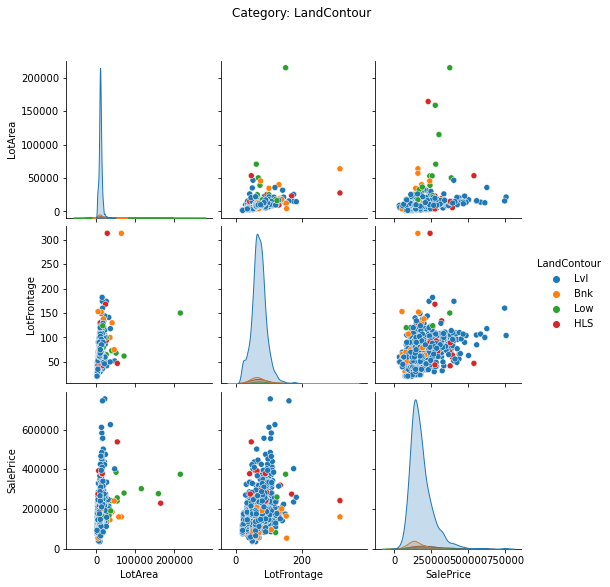

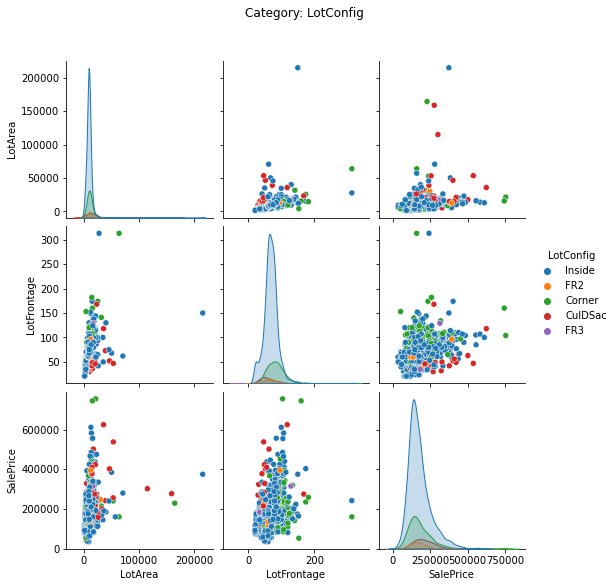

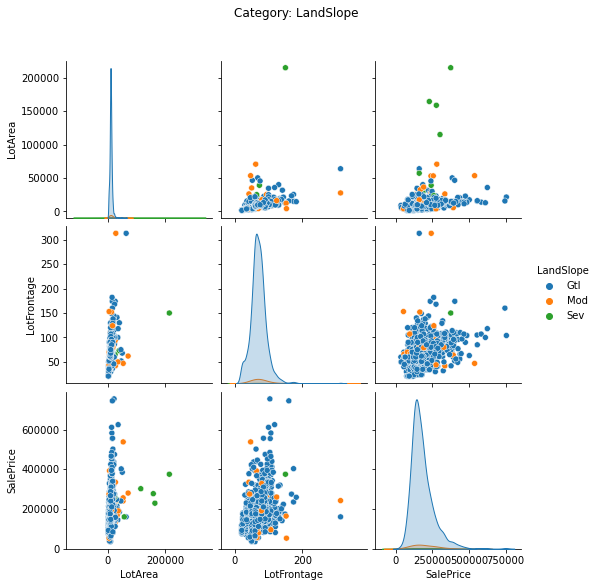

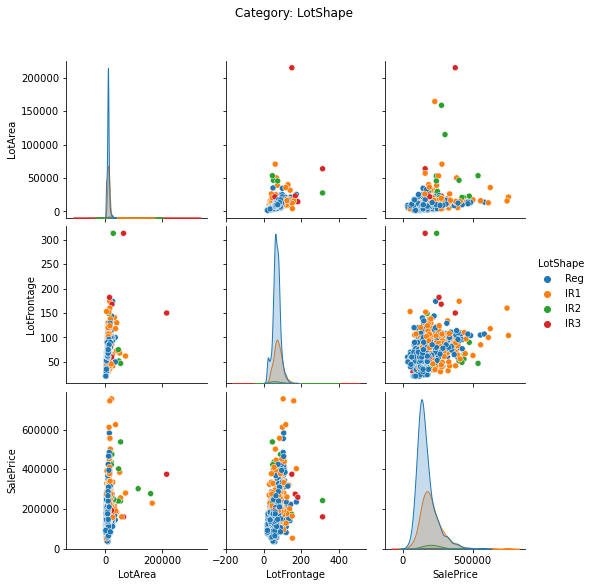

In [21]:
# obtain df with lot information
area_df = train_df[["LotArea","LotShape","LotFrontage","SalePrice","LandContour",
                    "LotConfig","LandSlope"]]
# categorical columns
lot_categories = ["LandContour","LotConfig","LandSlope","LotShape"]

# create a grid plot for each categorical value
for cat in lot_categories:
    quant_area = area_df[["LotArea","LotFrontage","SalePrice",cat]]
    g = sns.pairplot(quant_area, hue=cat, height=2.5,kind="scatter",diag_kind="kde")
    g.fig.suptitle("Category: " + cat, y=1.08)

Text(0.5, 0, 'Counts')

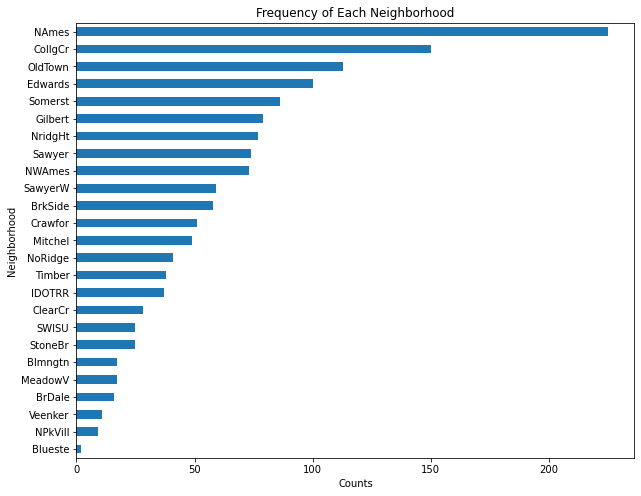

In [22]:
# create a df containing neighborhood categories
neighborhood = train_df[["Neighborhood"]]
# count how many times each neighborhood appears, rank, then plot
neighborhood.value_counts("Neighborhood",ascending=True).plot(kind="barh",figsize=(10,8))
plt.title("Frequency of Each Neighborhood")
plt.xlabel("Counts")

The more recent the remodel of a house the more value the home has.


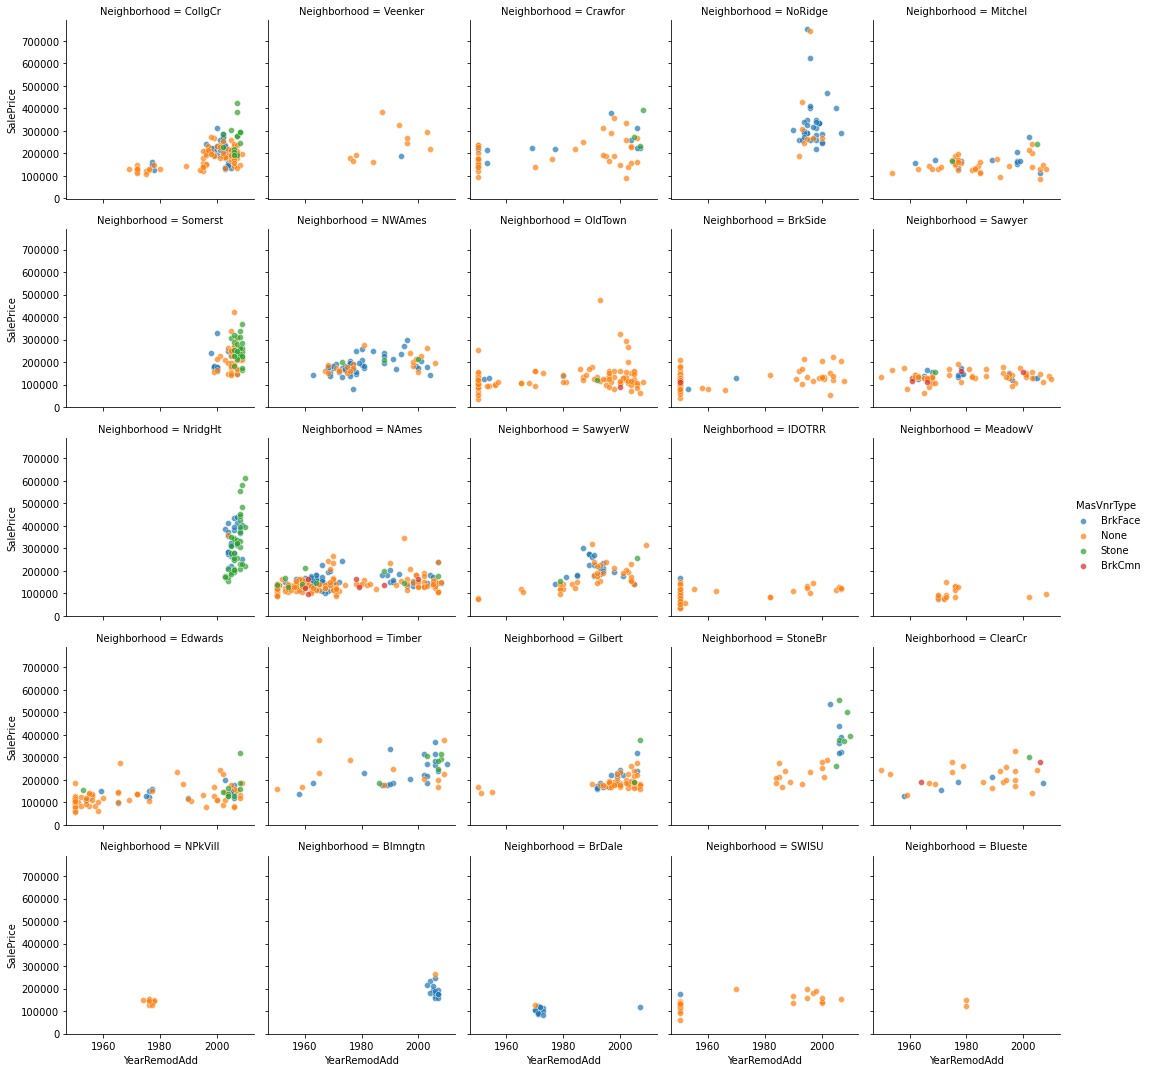

In [23]:
# dataframe to gain insights of home value of different neighborhoods
n_worth_df = train_df[["SalePrice","Neighborhood","YearRemodAdd","MasVnrType"]]
# plot year modeled against sale price for each neighborhood accounting for Masonry Veneer
g = sns.FacetGrid(n_worth_df, col="Neighborhood",col_wrap=5,hue="MasVnrType")
g.map(sns.scatterplot, "YearRemodAdd", "SalePrice", alpha=.7)
g.add_legend()
# insights
print("The more recent the remodel of a house the more value the home has.")

We can see Residential Low Density makes up the bulk of most Dwelling Types.


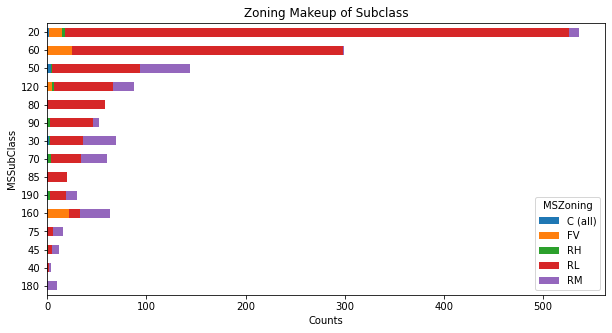

In [24]:
# create df of MSZoning and MSSubClass
MS_df = train_df[["MSZoning","MSSubClass"]]
# create data frame of counts by SubClass of Zoning
ms_df = MS_df.groupby("MSSubClass")["MSZoning"].value_counts().unstack().fillna(0)
# sort by RL of Zoning and create a stacked barh graph
ms_df.sort_values("RL").plot.barh(stacked=True,figsize=(10,5))
# plotting this way results in a more digestible graph
plt.title("Zoning Makeup of Subclass")
plt.xlabel("Counts")
# draw insights
print("We can see Residential Low Density makes up the bulk of most Dwelling Types.")